<a href="https://colab.research.google.com/github/troberts60/Molecular-Solubility/blob/main/Solubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict Solubility of Molecules

#1. Import rdkit

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-06-27 19:55:22--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   110MB/s    in 0.7s    

2021-06-27 19:55:23 (110 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

# 2. Get Data

In [2]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2021-06-27 19:56:54--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.002s  

2021-06-27 19:56:54 (34.1 MB/s) - ‘delaney.csv’ saved [58889/58889]



# 3. Read Data

In [3]:
import pandas as pd

In [4]:
solub = pd.read_csv('delaney.csv')
solub

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


#4. Input Data to rdkit object

In [5]:
from rdkit import Chem

molList = []
for element in solub.SMILES:
  mol = Chem.MolFromSmiles(element)
  molList.append(mol)

In [6]:
len(molList)

1144

## 5. Calculate LogP, Molecular Weight and Rotatable Bonds

In [7]:
import numpy as np
from rdkit.Chem import Descriptors

In [8]:

# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def create(smiles, verbose=False):

    mData = []
    for elem in smiles:
        mole=Chem.MolFromSmiles(elem)
        mData.append(mole)
    
    tData= np.arange(1,1)
    i=0
    for mol in mData:
        logP = Descriptors.MolLogP(mol)
        molWt = Descriptors.MolWt(mol)
        nrb = Descriptors.NumRotatableBonds(mol)

        row = np.array([logP,molWt,nrb])

        if(i==0):
          tData=row
        else:
          tData=np.vstack([tData, row])
        i=i+1

    colNames = ["MolLogP","MolWt","NumRotatableBonds"]
    descriptors = pd.DataFrame(data=tData,columns= colNames)

    return descriptors

In [9]:
d = create(solub.SMILES)
d

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#Aromatic Molecules

In [10]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
aroAtoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aroAtoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [11]:
def AroAt(m):
  aroAtoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aaCount = []
  for i in aroAtoms:
    if i==True:
      aaCount.append(1)
  sum_aaCount = sum(aaCount)
  return sum_aaCount

In [12]:
AroAt(m)

19

In [13]:
aroList = [AroAt(element) for element in molList]
aroList

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

In [14]:
aroPorport = [AroAt(element)/Descriptors.HeavyAtomCount(element) for element in molList]
aroPorport

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [15]:
df_aroProp = pd.DataFrame(aroPorport, columns=['AromaticProp'])
df_aroProp

,AromaticProp
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


In [16]:
X = pd.concat([d, df_aroProp], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProp
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


In [17]:
Y = solub.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [24]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
m1 = linear_model.LinearRegression()
m1.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#X-train

In [35]:
Y_pred_train = m1.predict(X_train)

In [36]:
print('Coefficents: ', m1.coef_)
print('Intercept: ', m1.intercept_)
print('MSE: %.2f' % mean_squared_error(Y_train, Y_pred_train))
print('R^2: %.2f' % r2_score(Y_train,Y_pred_train))


Coefficents:  [-0.74678734 -0.00637611 -0.00415241 -0.40945299]
Intercept:  0.21586497264298377
MSE: 0.96
R^2: 0.77


#X-test

In [31]:
Y_pred_test = m1.predict(X_test)

In [33]:
print('Coefficents: ', m1.coef_)
print('Intercept: ', m1.intercept_)
print('MSE: %.2f' % mean_squared_error(Y_test, Y_pred_test))
print('R^2: %.2f' % r2_score(Y_test,Y_pred_test))

Coefficents:  [-0.74678734 -0.00637611 -0.00415241 -0.40945299]
Intercept:  0.21586497264298377
MSE: 1.22
R^2: 0.76


#Linear Model Equation

In [34]:
yinter = '%.2f' % m1.intercept_
logP = '%.2f LogP' % m1.coef_[0]
mw = '%.4f MW' % m1.coef_[1]
rb = '%.4f RB' % m1.coef_[2]
ap = '%.2f AP' % m1.coef_[3]

In [38]:
print( 'LogS = '+ ' ' + yinter + ' ' + logP + ' ' + mw + ' ' + rb + ' ' + ap)

LogS =  0.22 -0.75 LogP -0.0064 MW -0.0042 RB -0.41 AP


#Full Data Set

In [39]:
fd = linear_model.LinearRegression()
fd.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
full_pred = m1.predict(X)

In [42]:
print('Coefficents: ', fd.coef_)
print('Intercept: ', fd.intercept_)
print('MSE: %.2f' % mean_squared_error(Y, full_pred))
print('R^2: %.2f' % r2_score(Y,full_pred))

Coefficents:  [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept:  0.2565006830997185
MSE: 1.01
R^2: 0.77


In [43]:
f_yinter = '%.2f' % fd.intercept_
f_logP = '%.2f LogP' % fd.coef_[0]
f_mw = '%.4f MW' % fd.coef_[1]
f_rb = '%.4f RB' % fd.coef_[2]
f_ap = '%.2f AP' % fd.coef_[3]

In [44]:
print( 'LogS = '+ ' ' + f_yinter + ' ' + f_logP + ' ' + f_mw + ' ' + f_rb + ' ' + f_ap)

LogS =  0.26 -0.74 LogP -0.0066 MW 0.0032 RB -0.42 AP


#Plot Graph

In [47]:
import matplotlib.pyplot as plt

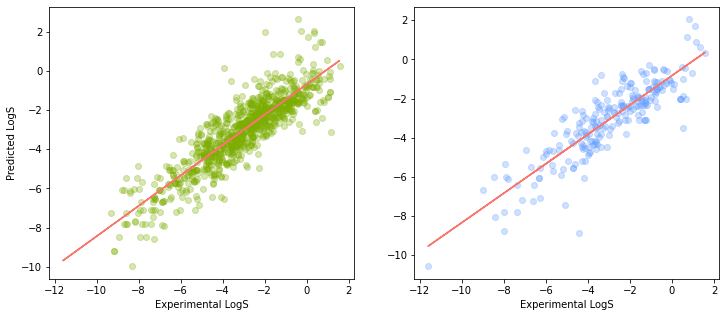

In [50]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(x=Y_train, y=Y_pred_train, c='#7CAE00', alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
t = np.polyfit(Y_train,Y_pred_train, 1)
r = np.poly1d(t)
plt.plot(Y_test,r(Y_test), "#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.subplot(1,2,2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

t = np.polyfit(Y_test,Y_pred_test,1)
r = np.poly1d(t)
plt.plot(Y_test,r(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()